After converting the model of "h5" format into "pb" format (using "export_model.ipynb"), the notebook will provide a guide to run inference by loading the model of "pb" format.

In [1]:
"""
Based on the work of Waleed Abdulla (Matterport)
Modified by github.com/wozhouh
"""

import tensorflow as tf
import cv2
import os
import sys
from tensorflow import flags
import numpy as np
import skimage
from time import time

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples", "coco"))  # To find local version
import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "weights")

# Local path to trained weights file
DEFAULT_MODEL_PATH = os.path.join(MODEL_DIR, "ResNet-101","mask_rcnn_coco.pb")
# DEFAULT_MODEL_PATH = os.path.join(MODEL_DIR, "GustavZ_mobile_mask_rcnn_coco.pb")

# Choose an image for test
IMG_PATH = os.path.join(ROOT_DIR, "images", "12283150_12d37e6389_z.jpg")

Using TensorFlow backend.


In [2]:
config = coco.CocoConfig()
class InferenceConfig(config.__class__):
    BACKBONE = "resnet101"
    IMAGE_MAX_DIM = 1024
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
# revised from "MaskRCNN.mold_inputs(self, images)" at "mmrcnn/model.py"
image = skimage.io.imread(IMG_PATH)
molded_image, window, scale, padding, crop = utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    min_scale=config.IMAGE_MIN_SCALE,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
molded_image = modellib.mold_image(molded_image, config)
image_meta = modellib.compose_image_meta(
    0, image.shape, molded_image.shape, window, scale,
    np.zeros([config.NUM_CLASSES], dtype=np.int32))
    
molded_images = np.stack([molded_image])
image_metas = np.stack([image_meta])
windows = np.stack([window])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 1024, 1024, 3)
(1, 93)
[[ 128    0  896 1024]]


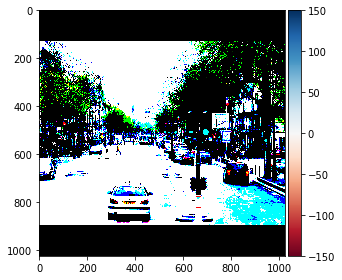

In [4]:
# Debug
print(molded_images.shape)
print(image_metas.shape)
print(windows)
# print(image_metas)  # [image_id(1), orginal_image_shape(3), image_shape(3), window(4), scale(1), num_classes(81)]
skimage.io.imshow(molded_images[0])

In [5]:
def get_anchors(config, image_shape):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = modellib.compute_backbone_shapes(config, image_shape)
        # Cache anchors and reuse if image shape is the same
        _anchor_cache = {}
        if not tuple(image_shape) in _anchor_cache:
            # Generate Anchors
            a = utils.generate_pyramid_anchors(
                config.RPN_ANCHOR_SCALES,
                config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                config.BACKBONE_STRIDES,
                config.RPN_ANCHOR_STRIDE)
            # Keep a copy of the latest anchors in pixel coordinates because
            # it's used in inspect_model notebooks.
            # TODO: Remove this after the notebook are refactored to not use it
            anchors = a
            # Normalize coordinates
            _anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
        return _anchor_cache[tuple(image_shape)]

In [6]:
# Anchors
image_shape = molded_images[0].shape
anchors = get_anchors(config, image_shape)
anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)

In [7]:
# Debug
print(anchors.shape)

(1, 261888, 4)


In [10]:
# Load the model of the .pb format
graph_def = tf.GraphDef.FromString(open(DEFAULT_MODEL_PATH, 'rb').read())

with tf.Graph().as_default():            
    _ = tf.import_graph_def(graph_def, name='')
    session = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    # Define the input and the output tensor
#     input_feed_dict = {"input_image:0": molded_images, 
#                        "input_image_meta:0": image_metas,
#                        "input_anchors:0": anchors}    
    input_feed_dict = {"input_image_2:0": molded_images, 
                       "input_image_meta_2:0": image_metas,
                       "input_anchors_2:0": anchors}
#     output_node = ["output_detections:0", "output_mrcnn_class:0", "output_mrcnn_bbox:0", 
#                    "output_mrcnn_mask:0", "output_rois:0", "output_rpn_class:0", "output_rpn_bbox:0"]
    mrcnn_output_list = session.run(["output_detections:0", "output_mrcnn_mask:0"], feed_dict=input_feed_dict)

In [11]:
# Debug
detections = mrcnn_output_list[0]
mrcnn_mask = mrcnn_output_list[1]
print(detections.shape)
print(mrcnn_mask.shape)

(1, 100, 6)
(1, 100, 28, 28, 81)


In [12]:
# copied from "MaskRCNN.unmold_detections(self, ...):" at "mmrcnn/model.py"
def unmold_detections(detections, mrcnn_mask, original_image_shape,
                      image_shape, window):
    # How many detections do we have?
    # Detections array is padded with zeros. Find the first class_id == 0.
    zero_ix = np.where(detections[:, 4] == 0)[0]
    N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

    # Extract boxes, class_ids, scores, and class-specific masks
    boxes = detections[:N, :4]
    class_ids = detections[:N, 4].astype(np.int32)
    scores = detections[:N, 5]
    masks = mrcnn_mask[np.arange(N), :, :, class_ids]

    # Translate normalized coordinates in the resized image to pixel
    # coordinates in the original image before resizing
    #print("original_image_shape: ",original_image_shape) #DEBUGGING
    #print("image_shape: ",image_shape) #DEBUGGING
    #print("window before norm: ",window) #DEBUGGING
    window = utils.norm_boxes(window, image_shape[:2])
    #print("window after norm: ",window) #DEBUGGING
    wy1, wx1, wy2, wx2 = window
    shift = np.array([wy1, wx1, wy1, wx1])
    wh = wy2 - wy1  # window height
    ww = wx2 - wx1  # window width
    scale = np.array([wh, ww, wh, ww])
    #print("scale: ",scale) #DEBUGGING
    # Convert boxes to normalized coordinates on the window
    boxes = np.divide(boxes - shift, scale) # ZERO DIVISION
    # Convert boxes to pixel coordinates on the original image
    boxes = utils.denorm_boxes(boxes, original_image_shape[:2])

    # Filter out detections with zero area. Happens in early training when
    # network weights are still random
    exclude_ix = np.where(
        (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
    if exclude_ix.shape[0] > 0:
        boxes = np.delete(boxes, exclude_ix, axis=0)
        class_ids = np.delete(class_ids, exclude_ix, axis=0)
        scores = np.delete(scores, exclude_ix, axis=0)
        masks = np.delete(masks, exclude_ix, axis=0)
        N = class_ids.shape[0]

    # Resize masks to original image size and set boundary threshold.
    full_masks = []
    for i in range(N):
        # Convert neural network mask to full size mask
        full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
        full_masks.append(full_mask)
    full_masks = np.stack(full_masks, axis=-1)\
        if full_masks else np.empty(masks.shape[1:3] + (0,))

    return boxes, class_ids, scores, full_masks

In [13]:
final_rois, final_class_ids, final_scores, final_masks =\
    unmold_detections(detections[0], mrcnn_mask[0], image.shape, molded_images[0].shape, windows[0])

In [14]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

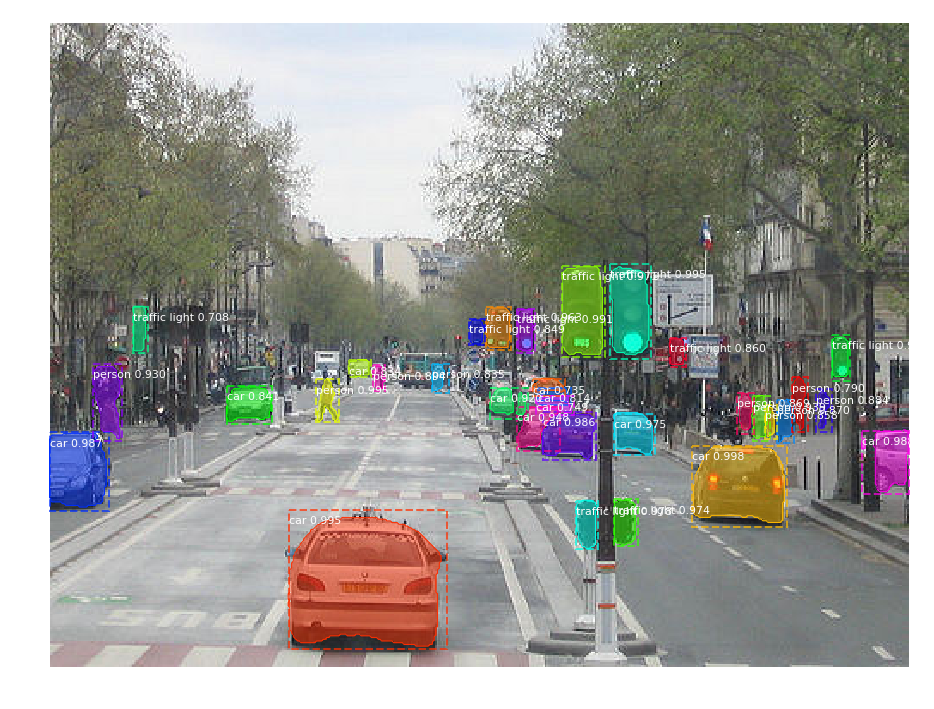

In [15]:
# visualization
visualize.display_instances(image, final_rois, final_masks, final_class_ids, 
                                class_names, final_scores)

In [16]:
# test the speed (fps) of Mask-RCNN
img_cnt = 100
with tf.Graph().as_default():            
    tf.import_graph_def(graph_def, name='')
    session = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    start_time = time()
    for k in range(img_cnt):
        mrcnn_output_list = session.run(["output_detections:0", "output_mrcnn_mask:0"], feed_dict=input_feed_dict)
        detections = mrcnn_output_list[0]
        mrcnn_mask = mrcnn_output_list[1]
        final_rois, final_class_ids, final_scores, final_masks = \
            unmold_detections(detections[0], mrcnn_mask[0], image.shape, molded_images[0].shape, windows[0])
    end_time = time()
    diff_time = end_time - start_time
    print("fps: %f" % (float(img_cnt) / diff_time))

fps: 3.486008


In [22]:
from tensorflow.python.client import timeline

run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

mrcnn_output_list = session.run(["output_detections:0", "output_mrcnn_mask:0"], 
                                feed_dict=input_feed_dict, 
                                options=run_options, 
                                run_metadata=run_metadata)
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open(os.path.join(MODEL_DIR, 'resnet101_mask_rcnn_timeline.json'), 'w') as f:
    f.write(ctf)
